<a href="https://colab.research.google.com/github/hyeon9698/Donghyeon_Cho/blob/main/210716.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 18 19:03:22 2018

@author: BTHANISH
"""

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import shap
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Reading the train and test files
train_prod_df = pd.read_csv('train.csv')
test_prod_df = pd.read_csv('test.csv')

In [ ]:
train_prod_df

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,422,open,jeonnam,178,20050211,214.0,nursing_hospital,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,7.439421e+08,1.875761e+08,0.0,5.943868e+08,2.776603e+09,2.769516e+09,1.797116e+09,7.086391e+06,1.191266e+10,1.171868e+10,1.198567e+08,0.0,8.715369e+09,1.520004e+09,0.000

In [ ]:
train_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [ ]:
pd.isnull(train_prod_df).sum() # NULL 확인

inst_id                0
OC                     0
sido                   0
sgg                    0
openDate               0
bedCount               5
instkind               1
revenue1               8
salescost1             8
sga1                   8
salary1                8
noi1                   8
noe1                   8
interest1              8
ctax1                  8
profit1                8
liquidAsset1           8
quickAsset1            8
receivableS1           8
inventoryAsset1        8
nonCAsset1             8
tanAsset1              8
OnonCAsset1            8
receivableL1           8
debt1                  8
liquidLiabilities1     8
shortLoan1             8
NCLiabilities1         8
longLoan1              8
netAsset1              8
surplus1               8
revenue2               8
salescost2             8
sga2                   8
salary2                8
noi2                   8
noe2                   8
interest2              8
ctax2                  8
profit2                8


# [데이터 설명](https://github.com/thinpig99/dacon-hospitalClose/blob/master/Re-Analysis-201229.ipynb)



In [ ]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

In [ ]:
#Converting the employee1 and 2 column as float in the train set as done for the test dataset
train_prod_df.employee1 = train_prod_df.employee1.astype('float')
train_prod_df.employee2 = train_prod_df.employee2.astype('float')
train_prod_df.OC= train_prod_df.OC.astype('str').str.replace(" ","")

In [ ]:
#Combining the train and test dataset
train_test_prod = train_prod_df.append(test_prod_df)

#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
factor_columns

Index(['OC', 'sido', 'instkind', 'ownerChange'], dtype='object')

In [ ]:
# difference - 변수를 분리해주는 pandas 함수
numeric_columns = train_test_prod.columns.difference(factor_columns)
numeric_columns

Index(['NCLiabilities1', 'NCLiabilities2', 'OnonCAsset1', 'OnonCAsset2',
       'bedCount', 'ctax1', 'ctax2', 'debt1', 'debt2', 'employee1',
       'employee2', 'inst_id', 'interest1', 'interest2', 'inventoryAsset1',
       'inventoryAsset2', 'liquidAsset1', 'liquidAsset2', 'liquidLiabilities1',
       'liquidLiabilities2', 'longLoan1', 'longLoan2', 'netAsset1',
       'netAsset2', 'noe1', 'noe2', 'noi1', 'noi2', 'nonCAsset1', 'nonCAsset2',
       'openDate', 'profit1', 'profit2', 'quickAsset1', 'quickAsset2',
       'receivableL1', 'receivableL2', 'receivableS1', 'receivableS2',
       'revenue1', 'revenue2', 'salary1', 'salary2', 'salescost1',
       'salescost2', 'sga1', 'sga2', 'sgg', 'shortLoan1', 'shortLoan2',
       'surplus1', 'surplus2', 'tanAsset1', 'tanAsset2'],
      dtype='object')

In [ ]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data>upper_bound)|(data<lower_bound))

# [iqr 설명 블로그](https://hwi-doc.tistory.com/entry/IQR-%EB%B0%A9%EC%8B%9D%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9D%B4%EC%83%81%EC%B9%98-%EB%8D%B0%EC%9D%B4%ED%84%B0Outlier-%EC%A0%9C%EA%B1%B0)

In [ ]:
outliers_iqr(test_prod_df.sgg)

(array([], dtype=int64),)

In [ ]:
test_prod_df.sgg

0      139
1      149
2      103
3       71
4       26
      ... 
122     33
123     74
124    116
125     76
126    163
Name: sgg, Length: 127, dtype: int64

In [ ]:
test_prod_df.sgg[3] = 999
test_prod_df.sgg


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0      139
1      149
2      103
3      999
4       26
      ... 
122     33
123     74
124    116
125     76
126    163
Name: sgg, Length: 127, dtype: int64

In [ ]:
outliers_iqr(test_prod_df.sgg)

(array([3]),)

In [ ]:
# 이 부분은 이해 잘 못 했음
# wrong entries가 있었다는데 왜 -999로 설정을 하지?

#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [ ]:
# LabelEncoder의 fit_transform 사용해서 object 객체들을 숫자로 레이블링
 
#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))
train_test_prod[factor_columns]

,OC,sido,instkind,ownerChange
0,2,2,5,2
1,2,9,3,2
2,2,8,5,2
3,2,10,3,2
4,2,9,3,2
...,...,...,...,...
122,0,13,6,0
123,0,8,7,2
124,0,8,4,0
125,0,11,2,2


In [ ]:
train_test_prod.OC.unique()

array([2, 1, 0])

In [ ]:
# OC 기준으로 train, test 나눔

#Splitting back data to train prod and test prod
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]
train_prod['OC'] = train_prod['OC'] - 1

#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])


train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]

In [ ]:
############################################################################
############ Random Forest
############################################################################
estimators = 10
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]

In [ ]:
############################################################################
############ GBM
############################################################################
estimators = 10
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators = estimators)
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]

In [ ]:
############################################################################
############ XGBOOST
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
#############내가 주석처리함
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (threshold).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param = {'objective' : 'binary:logistic',
         'max_depth' : 6,
         'eta': 0.3,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'silent' : 0
         }

nrounds = 2

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


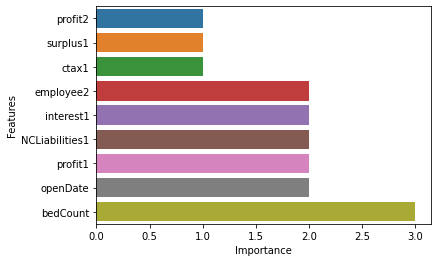

In [ ]:
np.random.seed(100)
xgb_model = xgb.train(param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,       # 내가 주석처리함
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model.predict(dtest_prod)

sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model.get_score().keys()), 
                        'Importance' : list(xgb_model.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp.Importance, xgb_Imp.Features)
plt.show()

In [ ]:
############################################################################
#Ensembling the three models
############################################################################

#Forming the ensemble dataset of the 3 models
ensemble = pd.DataFrame()
ensemble['inst_id'] = sub_XGB['inst_id']
ensemble['XGB'] = sub_XGB['OC']
ensemble['GBM'] = sub_GBM['OC']
ensemble['RF'] = sub_RF['OC']

# Taking the average of all 3 models
ensemble['ens'] = (ensemble['XGB'] + ensemble['GBM'] + ensemble['RF'])/3
ensemble['OC'] = (ensemble['ens']).astype('int') #0.7 as the threshold and above that the hospital is closed.

#Printing to see all the hospitals that are classified as closed 
print(ensemble.loc[ensemble['OC'] == 0, ])

ensemble = ensemble.loc[:, ['inst_id', 'OC']]

#ensemble.to_csv('ens_XGB_7_RF_4_GBM_2_39.csv', index = False)

     inst_id       XGB       GBM   RF       ens  OC
0          2  0.705177  0.966711  0.8  0.823963   0
1          5  0.657157  0.443177  0.8  0.633445   0
2          6  0.409096  0.666447  0.6  0.558514   0
3          8  0.645067  0.976222  0.8  0.807097   0
4         10  0.705177  0.966711  0.9  0.857296   0
..       ...       ...       ...  ...       ...  ..
122      424  0.409096  0.312302  0.3  0.340466   0
123      425  0.409096  0.580902  0.7  0.563333   0
124      429  0.409096  0.536108  0.7  0.548401   0
125      430  0.645067  0.976222  0.9  0.840430   0
126      431  0.409096  0.536108  0.6  0.515068   0

[127 rows x 6 columns]
